In [ ]:
%matplotlib inline
#libraries
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.constants import R_sun
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from sklearn.preprocessing import normalize
import astropy.units as u
import os
from PIL import Image
import glob
import subprocess
from sklearn.metrics import mean_squared_error

os.makedirs("frames", exist_ok=True)#-------->creating folder to save the PNG

#functions 

# convertion function 
def convertion_radians(degree):
    return np.deg2rad(degree)

#function to calculate angular velocity    
def spot_theta(rotation_period, spot_colatitude, relative_shear):
    """
    Parameters:
    - rotation_period: rotation period of the sta
    - initial_latitude: latitud of spot(radians)
    - relative_shear: parameter between pole and equator
    Returns:
    - angular velocity.
    """
    latitude = np.pi / 2 - spot_colatitude #------->the spehre latitude is from 0  to 2pi, so in equator the colatitude will be pi?2
    angular_vel_equa= 2*np.pi*u.rad/rotation_period
    angular_velocity = angular_vel_equa*(1-relative_shear*np.sin(latitude)**2)
    return angular_velocity  

  
def flux_plot(flux):
    ''' Function take a list normalizing the flux, converting the list in a csv file and rename the columns
    and return a plot    
    '''
    flux_norm = normalize([flux], norm="max")[0]
    df = pd.DataFrame(flux_norm)
    df.to_csv("lc_high.csv")
    lc = pd.read_csv("lc_high.csv")
    lc = lc.rename(columns={'Unnamed: 0': 'Days', '0': 'flux_normalized'})#-----> change the name of the columns
    lc.to_csv('lc_high_name.csv')
    return lc.plot(x="Days", y="flux_normalized", alpha=0.5)#----->simple plot of lc


# limb darkening function 
def limbdarkening(u):
    '''calculate a limb darkening lineal and put it to the spehre'''
    return (1 - u * (1 - mu))

#limb darkening quadratic     
def quadratic(u):
    """
    Calculates the intensity of a given cell in the stellar surface using a
    quadratic limb-darkening law.
  """

    return (1 - u * (1 - mu) - u * (1 - mu) ** 2)

#limb darkening logarithmic
def logarithmic(u):
    """
    Calculates the intensity of a given cell in the stellar surface using a
    logarithmic limb-darkening law.
    """
    
    return (1 - u * (1 - mu) - u * mu * np.log(mu) ** 2)



#function that create a gaussian mask to represent spots
def spot_mask(theta_mesh, spot_theta_rad,phi_mesh,spot_phi_rad,spot_radius_rad):
    '''function for creating spot mask, that could change the size and shape of the spot
    using a gaussian function
    '''
    delta_theta = np.arccos(np.cos(theta_mesh - spot_theta_rad.value))
    delta_phi = np.abs(phi_mesh - spot_phi_rad)
    distance_squared = delta_theta**2 + delta_phi**2
    sigma_squared = (spot_radius_rad / 2)**2
    return np.exp(-distance_squared**2 / (2* sigma_squared))

def spot_mask_binary(theta_mesh, spot_theta_rad, phi_mesh, spot_phi_rad, spot_radius_rad):
    """Máscara binaria: 1 dentro del radio de la mancha, 0 fuera"""
    delta_theta = np.arccos(np.cos(theta_mesh - spot_theta_rad.value))
    delta_phi = np.abs(phi_mesh - spot_phi_rad)
    distance_squared = delta_theta**2 + delta_phi**2
    return np.where(distance_squared <= spot_radius_rad**2, 1, 0)


##function that creates spots

def add_spots(latitude_deg, longitude_deg, radii_deg):

    colatitude_rad = np.deg2rad(90 - latitude_deg)
    longitude_rad = np.deg2rad(longitude_deg)
    radii_rad = np.deg2rad(radii_deg)
    ang_vel = spot_theta(rotation_period, colatitude_rad, 0.2)  

    spots.append({'theta': longitude_rad * u.rad,'phi': colatitude_rad,'radius': radii_rad,'angular_velocity': ang_vel})



### function to create gif
def gif(input_pattern="frames/frame_%03d.png",output_gif="output.gif",palette="palette.png",framerate=17):
    """
    Creating GIF with ffmpeg.
    
    Parameters:
        input_pattern (str): Input pattern of the numbered images (e.g. 'frames/frame_%03d.png')
     output_gif (str): Name of the output GIF file
     palette (str): Name of the temporary palette file
     framerate (int): Frames per second of the GIF
    """
    # color palette
    palette_cmd = ["ffmpeg","-y","-i", input_pattern,"-vf", "palettegen",palette]

    # gif creation
    gif_cmd = ["ffmpeg","-y","-framerate", str(framerate),"-i", input_pattern,"-i", palette,"-lavfi", "paletteuse",output_gif]

    try:
        print("generating color palette")
        subprocess.run(palette_cmd, check=True)

        print("creating gif")
        subprocess.run(gif_cmd, check=True)

        print(f" GIF done: {output_gif}")
    except subprocess.CalledProcessError as e:
        print("something wrong:", e)

def flux_plot():
    '''
    Function take a list normalizing the flux, converting the list in a csv file and rename the columns
    and return a plot 

    '''
    frame_files = sorted(glob.glob("frames/frame_*.png"))
    fluxes = []

    for filename in frame_files:
        img = Image.open(filename).convert('L')  # Grayscale
        img_array = np.array(img, dtype=np.float64)
        flux_total = np.sum(img_array)
        fluxes.append(flux_total)

    # Normalized fluxes
    flux_norm = normalize([fluxes], norm="max")[0]
    df = pd.DataFrame(flux_norm)

    # Creating columns
    df.index.name = 'Frame'
    df.reset_index(inplace=True)
    #changing frames for days
    df['Days'] = df['Frame'] *(cadence_time.to(u.day)).value
    df = df.rename(columns={0: 'flux_normalized'})
    df = df[['Days', 'flux_normalized']]  

    # saving csv
    df.to_csv("lc_dummy.csv", index=False)

    # Graficar
    ax = df.plot(x="Days", y="flux_normalized", alpha=0.5, linestyle='--', color ="blue")
    ax.set_xlabel("Time [days]")
    ax.set_ylabel("Normalized Flux")
    ax.set_title("Lightcurve from PNG frames")
    plt.tight_layout()
    plt.show()

#animation Function

def animate(i, gray_texture, mu,theta_mesh, phi_mesh,
            x, y, z, ax_sphere, elev, azim, total_frames):#ax_curve, line_curve, fluxes, total_frames):
    """ Function where is created the motion and call functions"""
    ax_sphere.clear()
    ax_sphere.set_axis_off()
    ax_sphere.view_init(elev=elev, azim=azim)
    texture = np.copy(gray_texture)

    for spot in spots:
        theta_mov = spot['theta'] + spot['angular_velocity'] * i * cadence_time.to(u.day)
        mask = spot_mask(theta_mesh, theta_mov, phi_mesh, spot['phi'], spot['radius'])
        texture *= (1 -  mask)  # Add texture to spot

    # Plot surface
    surf = ax_sphere.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.gray(texture), shade=False)
    print(f"Procesando frame {i+1}/{total_frames}, motion {theta_mov:.2f}",  end='\r')  # -------> to see the process
    
    # Png saves
    filename = f"frames/frame_{i:03d}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0)
    return[surf]

if __name__ == '__main__':
    
    # Stellar parameters 
    r = 1* u.R_sun
    res = 60#--->resolution
    constant = 0.8  # limb darkening coefficient
    rotation_period = 1* u.day #--->rotation period of the star
    
    # Point of view of the sphere
    elev = 0
    azim = 0
    
     #list of spots
    spots = []
    
    #adding spots
    #add_spots(30, 45, 10)
    #add_spots(-20, 90, 15)
    add_spots(80, 30, 30)

    
    #parameters of how many days periods
    observing_baseline_days = 5* u.day#----> Observation time
    cadence_time = 30 * u.minute#----> Cadence
    
    # frames
    total_frames = (observing_baseline_days / cadence_time).decompose().value
    total_frames = int(total_frames) 
    
    #Parameter of differential rotation
    relative_shear_coeff = 0.2
    
    #creating angles
    theta = np.linspace(0, 2*np.pi, res)
    phi = np.linspace(0, np.pi, res)
    
    #meshgrid for creation of the sphere surface
    theta_mesh, phi_mesh = np.meshgrid(theta, phi)
    
    x = r * np.sin(phi_mesh) * np.cos(theta_mesh)
    y = r * np.sin(phi_mesh) * np.sin(theta_mesh)
    z = r * np.cos(phi_mesh)
    
    # gray texture 
    gray_texture = np.ones((res, res))  # intensity white==1
    
    #convertion paraneters
    elev_rad = convertion_radians(elev)
    azim_rad = convertion_radians(azim)
    
    v_x = np.cos(elev_rad) * np.cos(azim_rad)
    v_y = np.cos(elev_rad) * np.sin(azim_rad)
    v_z = np.sin(elev_rad)
    
    # Limb darkening
    mu = (x * v_x + y * v_y + z * v_z) / r
    mu = np.clip(mu, 0, 1)
    
    lineal_darkening = limbdarkening(constant)
    gray_texture *= lineal_darkening
      
    # Figure
    plt.style.use('dark_background')# -----> dark background
    fig = plt.figure(figsize=(12, 6))
    ax_sphere = fig.add_subplot(projection='3d') 

    ax_sphere.set_box_aspect((0.98, 1, 0.95))#-------> symtries of the sun 
 
    ax_sphere.set_axis_off()
    
    
    for i in range(total_frames):
        animate(i, gray_texture, mu,theta_mesh, phi_mesh, x, y, z, ax_sphere, elev, azim, total_frames)
        plt.savefig(f"frames/frame_{i:03d}.png", dpi=300)

    gif(input_pattern="frames/frame_%03d.png", output_gif="lc_dummy.gif",framerate=15)
    flux_plot()

  


Procesando frame 7/240, motion 1.16 rad

### Taking the images and making a mean of intensity

### creating a gif again

 Simulatin lat=-60, lon=0, radius=5
generating color palette, motion 26.59 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 25 q=-0.0 Lsize=     672kB time=00:00:15.94 bitrate= 345.3kbits/s speed=1.64x    
video:672kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.002907%


 GIF done: gif_l-60_lo0_r5.gif
 Simulatin lat=-60, lon=0, radius=10
generating color palette, motion 26.59 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l-60_lo0_r10.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 23 q=-0.0 Lsize=    1116kB time=00:00:15.94 bitrate= 573.5kbits/s speed=1.51x    
video:1116kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001750%


 GIF done: gif_l-60_lo0_r10.gif
 Simulatin lat=-60, lon=0, radius=15
generating color palette, motion 26.59 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 24 q=-0.0 Lsize=    1545kB time=00:00:15.94 bitrate= 794.2kbits/s speed= 1.6x    
video:1545kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001264%


 GIF done: gif_l-60_lo0_r15.gif
 Simulatin lat=-60, lon=60, radius=5
generating color palette, motion 27.64 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 24 q=-0.0 Lsize=     627kB time=00:00:15.94 bitrate= 322.2kbits/s speed= 1.6x    
video:627kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.003116%


 GIF done: gif_l-60_lo60_r5.gif
 Simulatin lat=-60, lon=60, radius=10
generating color palette, motion 27.64 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 25 q=-0.0 Lsize=    1039kB time=00:00:15.94 bitrate= 534.0kbits/s speed=1.65x    
video:1039kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001880%


 GIF done: gif_l-60_lo60_r10.gif
 Simulatin lat=-60, lon=60, radius=15
generating color palette, motion 27.64 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 25 q=-0.0 Lsize=    1442kB time=00:00:15.94 bitrate= 741.2kbits/s speed=1.65x    
video:1442kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001354%


 GIF done: gif_l-60_lo60_r15.gif
 Simulatin lat=-60, lon=120, radius=5
generating color palette, motion 28.69 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l-60_lo120_r5.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 21 q=-0.0 Lsize=     610kB time=00:00:15.94 bitrate= 313.6kbits/s speed=1.39x    
video:610kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.003201%


 GIF done: gif_l-60_lo120_r5.gif
 Simulatin lat=-60, lon=120, radius=10
generating color palette, motion 28.69 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=    1012kB time=00:00:15.94 bitrate= 519.9kbits/s speed=1.29x    
video:1012kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001931%


 GIF done: gif_l-60_lo120_r10.gif
 Simulatin lat=-60, lon=120, radius=15
generating color palette, motion 28.69 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l-60_lo120_r15.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 20 q=-0.0 Lsize=    1399kB time=00:00:15.94 bitrate= 718.9kbits/s speed=1.34x    
video:1399kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001396%


 GIF done: gif_l-60_lo120_r15.gif
 Simulatin lat=-60, lon=180, radius=5
generating color palette, motion 29.73 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 18 q=-0.0 Lsize=     612kB time=00:00:15.94 bitrate= 314.6kbits/s speed=1.19x    
video:612kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.003191%


 GIF done: gif_l-60_lo180_r5.gif
 Simulatin lat=-60, lon=180, radius=10
generating color palette, motion 29.73 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l-60_lo180_r10.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 20 q=-0.0 Lsize=    1014kB time=00:00:15.94 bitrate= 521.0kbits/s speed= 1.3x    
video:1014kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001927%


 GIF done: gif_l-60_lo180_r10.gif
 Simulatin lat=-60, lon=180, radius=15
generating color palette, motion 29.73 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=    1406kB time=00:00:15.94 bitrate= 722.6kbits/s speed=1.27x    
video:1406kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001389%


 GIF done: gif_l-60_lo180_r15.gif
 Simulatin lat=-60, lon=240, radius=5
generating color palette, motion 30.78 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 20 q=-0.0 Lsize=     646kB time=00:00:15.94 bitrate= 332.1kbits/s speed= 1.3x    
video:646kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.003022%


 GIF done: gif_l-60_lo240_r5.gif
 Simulatin lat=-60, lon=240, radius=10
generating color palette, motion 30.78 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=    1074kB time=00:00:15.94 bitrate= 551.9kbits/s speed=1.28x    
video:1074kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001819%


 GIF done: gif_l-60_lo240_r10.gif
 Simulatin lat=-60, lon=240, radius=15
generating color palette, motion 30.78 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=    1489kB time=00:00:15.94 bitrate= 765.2kbits/s speed=1.28x    
video:1489kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001312%


 GIF done: gif_l-60_lo240_r15.gif
 Simulatin lat=-60, lon=300, radius=5
generating color palette, motion 31.83 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=     681kB time=00:00:15.94 bitrate= 349.9kbits/s speed=1.29x    
video:681kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.002869%


 GIF done: gif_l-60_lo300_r5.gif
 Simulatin lat=-60, lon=300, radius=10
generating color palette, motion 31.83 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l-60_lo300_r10.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 19 q=-0.0 Lsize=    1135kB time=00:00:15.94 bitrate= 583.1kbits/s speed=1.28x    
video:1135kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001722%


 GIF done: gif_l-60_lo300_r10.gif
 Simulatin lat=-60, lon=300, radius=15
generating color palette, motion 31.83 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

 GIF done: gif_l-60_lo300_r15.gif
 Simulatin lat=-60, lon=360, radius=5
generating color palette, motion 32.88 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Input #0, image2, from 'frames/frame_%03d.png':
  Duration: 00:00:16.00, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 1386x1386 [SAR 11811:11811 DAR 1:1], 15 fps, 15 tbr, 15 tbn, 15 tbc
Input #1, png_pipe, from 'palette.png':
  Duration: N/A, bitrate: N/A
    Stream #1:0: Video: png, rgba(pc), 16x16 [SAR 1:1 DAR 1:1], 25 tbr, 25 tbn, 25 tbc
Stream mapping:
  Stream #0:0 (png) -> paletteuse:default
  Stream #1:0 (png) -> paletteuse:palette
  paletteuse -> Stream #0:0 (gif)
Press [q] to stop, [?] for help
[image2 @ 0x5f48a7ab9100] Thread message queue blocking; consider raising the thread_queue_size option (current value: 8)
Output #0, gif, to 'gif_l-60_lo360_r5.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 20 q=-0.0 Lsize=     672kB time=00:00:15.94 bitrate= 345.3kbits/

 GIF done: gif_l-60_lo360_r5.gif
 Simulatin lat=-60, lon=360, radius=10
generating color palette, motion 32.88 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=    1116kB time=00:00:15.94 bitrate= 573.5kbits/s speed=1.28x    
video:1116kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001750%


 GIF done: gif_l-60_lo360_r10.gif
 Simulatin lat=-60, lon=360, radius=15
generating color palette, motion 32.88 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 18 q=-0.0 Lsize=    1545kB time=00:00:15.94 bitrate= 794.2kbits/s speed=1.22x    
video:1545kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001264%


 GIF done: gif_l-60_lo360_r15.gif
 Simulatin lat=-40, lon=0, radius=5
generating color palette, motion 28.70 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l-40_lo0_r5.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 19 q=-0.0 Lsize=     985kB time=00:00:15.94 bitrate= 506.1kbits/s speed=1.28x    
video:985kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001983%


 GIF done: gif_l-40_lo0_r5.gif
 Simulatin lat=-40, lon=0, radius=10
generating color palette, motion 28.70 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l-40_lo0_r10.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 19 q=-0.0 Lsize=    1672kB time=00:00:15.94 bitrate= 859.2kbits/s speed=1.28x    
video:1672kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001168%


 GIF done: gif_l-40_lo0_r10.gif
 Simulatin lat=-40, lon=0, radius=15
generating color palette, motion 28.70 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=    2277kB time=00:00:15.94 bitrate=1170.1kbits/s speed=1.26x    
video:2277kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000858%


 GIF done: gif_l-40_lo0_r15.gif
 Simulatin lat=-40, lon=60, radius=5
generating color palette, motion 29.75 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l-40_lo60_r5.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 19 q=-0.0 Lsize=     912kB time=00:00:15.94 bitrate= 468.6kbits/s speed=1.26x    
video:912kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.002142%


 GIF done: gif_l-40_lo60_r5.gif
 Simulatin lat=-40, lon=60, radius=10
generating color palette, motion 29.75 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=    1549kB time=00:00:15.94 bitrate= 795.8kbits/s speed=1.27x    
video:1549kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001261%


 GIF done: gif_l-40_lo60_r10.gif
 Simulatin lat=-40, lon=60, radius=15
generating color palette, motion 29.75 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l-40_lo60_r15.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 19 q=-0.0 Lsize=    2115kB time=00:00:15.94 bitrate=1087.1kbits/s speed=1.26x    
video:2115kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000923%


 GIF done: gif_l-40_lo60_r15.gif
 Simulatin lat=-40, lon=120, radius=5
generating color palette, motion 30.79 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l-40_lo120_r5.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 20 q=-0.0 Lsize=     946kB time=00:00:15.94 bitrate= 485.9kbits/s speed=1.31x    
video:946kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.002066%


 GIF done: gif_l-40_lo120_r5.gif
 Simulatin lat=-40, lon=120, radius=10
generating color palette, motion 30.79 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l-40_lo120_r10.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 19 q=-0.0 Lsize=    1601kB time=00:00:15.94 bitrate= 822.8kbits/s speed=1.27x    
video:1601kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001220%


 GIF done: gif_l-40_lo120_r10.gif
 Simulatin lat=-40, lon=120, radius=15
generating color palette, motion 30.79 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l-40_lo120_r15.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 19 q=-0.0 Lsize=    2180kB time=00:00:15.94 bitrate=1120.3kbits/s speed=1.27x    
video:2180kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000896%


 GIF done: gif_l-40_lo120_r15.gif
 Simulatin lat=-40, lon=180, radius=5
generating color palette, motion 31.84 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=    1024kB time=00:00:15.94 bitrate= 526.3kbits/s speed=1.29x    
video:1024kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001907%


 GIF done: gif_l-40_lo180_r5.gif
 Simulatin lat=-40, lon=180, radius=10
generating color palette, motion 31.84 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=    1737kB time=00:00:15.94 bitrate= 892.7kbits/s speed=1.25x    
video:1737kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001124%


 GIF done: gif_l-40_lo180_r10.gif
 Simulatin lat=-40, lon=180, radius=15
generating color palette, motion 31.84 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l-40_lo180_r15.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 19 q=-0.0 Lsize=    2365kB time=00:00:15.94 bitrate=1215.5kbits/s speed=1.26x    
video:2365kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000826%


 GIF done: gif_l-40_lo180_r15.gif
 Simulatin lat=-40, lon=240, radius=5
generating color palette, motion 32.89 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=    1079kB time=00:00:15.94 bitrate= 554.6kbits/s speed=1.29x    
video:1079kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001810%


 GIF done: gif_l-40_lo240_r5.gif
 Simulatin lat=-40, lon=240, radius=10
generating color palette, motion 32.89 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Input #0, image2, from 'frames/frame_%03d.png':
  Duration: 00:00:16.00, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 1386x1386 [SAR 11811:11811 DAR 1:1], 15 fps, 15 tbr, 15 tbn, 15 tbc
Input #1, png_pipe, from 'palette.png':
  Duration: N/A, bitrate: N/A
    Stream #1:0: Video: png, rgba(pc), 16x16 [SAR 1:1 DAR 1:1], 25 tbr, 25 tbn, 25 tbc
Stream mapping:
  Stream #0:0 (png) -> paletteuse:default
  Stream #1:0 (png) -> paletteuse:palette
  paletteuse -> Stream #0:0 (gif)
Press [q] to stop, [?] for help
[image2 @ 0x650663c30100] Thread message queue blocking; consider raising the thread_queue_size option (current value: 8)
Output #0, gif, to 'gif_l-40_lo240_r10.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 19 q=-0.0 Lsize=    1836kB time=00:00:15.94 bitrate= 943.7kbits

 GIF done: gif_l-40_lo240_r10.gif
 Simulatin lat=-40, lon=240, radius=15
generating color palette, motion 32.89 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 25 q=-0.0 Lsize=    2504kB time=00:00:15.94 bitrate=1286.8kbits/s speed=1.66x    
video:2504kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000780%


 GIF done: gif_l-40_lo240_r15.gif
 Simulatin lat=-40, lon=300, radius=5
generating color palette, motion 33.94 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 25 q=-0.0 Lsize=    1061kB time=00:00:15.94 bitrate= 545.0kbits/s speed=1.68x    
video:1061kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001842%


 GIF done: gif_l-40_lo300_r5.gif
 Simulatin lat=-40, lon=300, radius=10
generating color palette, motion 33.94 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 25 q=-0.0 Lsize=    1803kB time=00:00:15.94 bitrate= 926.8kbits/s speed=1.65x    
video:1803kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001083%


 GIF done: gif_l-40_lo300_r10.gif
 Simulatin lat=-40, lon=300, radius=15
generating color palette, motion 33.94 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 26 q=-0.0 Lsize=    2453kB time=00:00:15.94 bitrate=1260.6kbits/s speed= 1.7x    
video:2453kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000796%


 GIF done: gif_l-40_lo300_r15.gif
 Simulatin lat=-40, lon=360, radius=5
generating color palette, motion 34.98 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l-40_lo360_r5.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 26 q=-0.0 Lsize=     985kB time=00:00:15.94 bitrate= 506.1kbits/s speed=1.71x    
video:985kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001983%


 GIF done: gif_l-40_lo360_r5.gif
 Simulatin lat=-40, lon=360, radius=10
generating color palette, motion 34.98 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Input #0, image2, from 'frames/frame_%03d.png':
  Duration: 00:00:16.00, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 1386x1386 [SAR 11811:11811 DAR 1:1], 15 fps, 15 tbr, 15 tbn, 15 tbc
Input #1, png_pipe, from 'palette.png':
  Duration: N/A, bitrate: N/A
    Stream #1:0: Video: png, rgba(pc), 16x16 [SAR 1:1 DAR 1:1], 25 tbr, 25 tbn, 25 tbc
Stream mapping:
  Stream #0:0 (png) -> paletteuse:default
  Stream #1:0 (png) -> paletteuse:palette
  paletteuse -> Stream #0:0 (gif)
Press [q] to stop, [?] for help
[image2 @ 0x63839ee4b100] Thread message queue blocking; consider raising the thread_queue_size option (current value: 8)
Output #0, gif, to 'gif_l-40_lo360_r10.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 26 q=-0.0 Lsize=    1672kB time=00:00:15.94 bitrate= 859.2kbits

 GIF done: gif_l-40_lo360_r10.gif
 Simulatin lat=-40, lon=360, radius=15
generating color palette, motion 34.98 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 27 q=-0.0 Lsize=    2277kB time=00:00:15.94 bitrate=1170.1kbits/s speed=1.79x    
video:2277kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000858%


 GIF done: gif_l-40_lo360_r15.gif
 Simulatin lat=-20, lon=0, radius=5
generating color palette, motion 30.55 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 26 q=-0.0 Lsize=    1176kB time=00:00:15.94 bitrate= 604.3kbits/s speed=1.75x    
video:1176kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001661%


 GIF done: gif_l-20_lo0_r5.gif
 Simulatin lat=-20, lon=0, radius=10
generating color palette, motion 30.55 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 24 q=-0.0 Lsize=    1990kB time=00:00:15.94 bitrate=1022.8kbits/s speed=1.56x    
video:1990kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000981%


 GIF done: gif_l-20_lo0_r10.gif
 Simulatin lat=-20, lon=0, radius=15
generating color palette, motion 30.55 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 25 q=-0.0 Lsize=    2727kB time=00:00:15.94 bitrate=1401.4kbits/s speed=1.69x    
video:2727kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000716%


 GIF done: gif_l-20_lo0_r15.gif
 Simulatin lat=-20, lon=60, radius=5
generating color palette, motion 31.60 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l-20_lo60_r5.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 26 q=-0.0 Lsize=    1181kB time=00:00:15.94 bitrate= 607.2kbits/s speed=1.71x    
video:1181kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001653%


 GIF done: gif_l-20_lo60_r5.gif
 Simulatin lat=-20, lon=60, radius=10
generating color palette, motion 31.60 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 27 q=-0.0 Lsize=    2001kB time=00:00:15.94 bitrate=1028.6kbits/s speed=1.78x    
video:2001kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000976%


 GIF done: gif_l-20_lo60_r10.gif
 Simulatin lat=-20, lon=60, radius=15
generating color palette, motion 31.60 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 27 q=-0.0 Lsize=    2747kB time=00:00:15.94 bitrate=1411.8kbits/s speed=1.79x    
video:2747kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000711%


 GIF done: gif_l-20_lo60_r15.gif
 Simulatin lat=-20, lon=120, radius=5
generating color palette, motion 32.65 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 26 q=-0.0 Lsize=    1234kB time=00:00:15.94 bitrate= 634.3kbits/s speed=1.71x    
video:1234kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001583%


 GIF done: gif_l-20_lo120_r5.gif
 Simulatin lat=-20, lon=120, radius=10
generating color palette, motion 32.65 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l-20_lo120_r10.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 27 q=-0.0 Lsize=    2090kB time=00:00:15.94 bitrate=1074.3kbits/s speed=1.76x    
video:2090kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000934%


 GIF done: gif_l-20_lo120_r10.gif
 Simulatin lat=-20, lon=120, radius=15
generating color palette, motion 32.65 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l-20_lo120_r15.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 21 q=-0.0 Lsize=    2865kB time=00:00:15.94 bitrate=1472.4kbits/s speed=1.42x    
video:2865kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000682%


 GIF done: gif_l-20_lo120_r15.gif
 Simulatin lat=-20, lon=180, radius=5
generating color palette, motion 33.69 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 27 q=-0.0 Lsize=    1248kB time=00:00:15.94 bitrate= 641.2kbits/s speed=1.81x    
video:1248kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001565%


 GIF done: gif_l-20_lo180_r5.gif
 Simulatin lat=-20, lon=180, radius=10
generating color palette, motion 33.69 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 27 q=-0.0 Lsize=    2115kB time=00:00:15.94 bitrate=1086.9kbits/s speed=1.77x    
video:2115kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000924%


 GIF done: gif_l-20_lo180_r10.gif
 Simulatin lat=-20, lon=180, radius=15
generating color palette, motion 33.69 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 27 q=-0.0 Lsize=    2905kB time=00:00:15.94 bitrate=1493.2kbits/s speed= 1.8x    
video:2905kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000672%


 GIF done: gif_l-20_lo180_r15.gif
 Simulatin lat=-20, lon=240, radius=5
generating color palette, motion 34.74 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 25 q=-0.0 Lsize=    1248kB time=00:00:15.94 bitrate= 641.4kbits/s speed=1.64x    
video:1248kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001565%


 GIF done: gif_l-20_lo240_r5.gif
 Simulatin lat=-20, lon=240, radius=10
generating color palette, motion 34.74 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 26 q=-0.0 Lsize=    2114kB time=00:00:15.94 bitrate=1086.2kbits/s speed=1.73x    
video:2114kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000924%


 GIF done: gif_l-20_lo240_r10.gif
 Simulatin lat=-20, lon=240, radius=15
generating color palette, motion 34.74 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 26 q=-0.0 Lsize=    2901kB time=00:00:15.94 bitrate=1490.8kbits/s speed=1.74x    
video:2901kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000673%


 GIF done: gif_l-20_lo240_r15.gif
 Simulatin lat=-20, lon=300, radius=5
generating color palette, motion 35.79 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 26 q=-0.0 Lsize=    1224kB time=00:00:15.94 bitrate= 628.8kbits/s speed=1.74x    
video:1224kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001596%


 GIF done: gif_l-20_lo300_r5.gif
 Simulatin lat=-20, lon=300, radius=10
generating color palette, motion 35.79 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l-20_lo300_r10.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 27 q=-0.0 Lsize=    2063kB time=00:00:15.94 bitrate=1060.0kbits/s speed=1.77x    
video:2063kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000947%


 GIF done: gif_l-20_lo300_r10.gif
 Simulatin lat=-20, lon=300, radius=15
generating color palette, motion 35.79 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 26 q=-0.0 Lsize=    2830kB time=00:00:15.94 bitrate=1454.7kbits/s speed=1.72x    
video:2830kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000690%


 GIF done: gif_l-20_lo300_r15.gif
 Simulatin lat=-20, lon=360, radius=5
generating color palette, motion 36.84 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 27 q=-0.0 Lsize=    1176kB time=00:00:15.94 bitrate= 604.3kbits/s speed=1.78x    
video:1176kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001661%


 GIF done: gif_l-20_lo360_r5.gif
 Simulatin lat=-20, lon=360, radius=10
generating color palette, motion 36.84 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 27 q=-0.0 Lsize=    1990kB time=00:00:15.94 bitrate=1022.8kbits/s speed=1.77x    
video:1990kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000981%


 GIF done: gif_l-20_lo360_r10.gif
 Simulatin lat=-20, lon=360, radius=15
generating color palette, motion 36.84 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 27 q=-0.0 Lsize=    2727kB time=00:00:15.94 bitrate=1401.4kbits/s speed=1.78x    
video:2727kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000716%


 GIF done: gif_l-20_lo360_r15.gif
 Simulatin lat=0, lon=0, radius=5
generating color palette, motion 31.29 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 26 q=-0.0 Lsize=    1194kB time=00:00:15.94 bitrate= 613.5kbits/s speed=1.74x    
video:1194kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001636%


 GIF done: gif_l0_lo0_r5.gif
 Simulatin lat=0, lon=0, radius=10
generating color palette, motion 31.29 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 25 q=-0.0 Lsize=    2103kB time=00:00:15.94 bitrate=1080.8kbits/s speed=1.66x    
video:2103kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000929%


 GIF done: gif_l0_lo0_r10.gif
 Simulatin lat=0, lon=0, radius=15
generating color palette, motion 31.29 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 26 q=-0.0 Lsize=    2899kB time=00:00:15.94 bitrate=1489.7kbits/s speed=1.73x    
video:2899kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000674%


 GIF done: gif_l0_lo0_r15.gif
 Simulatin lat=0, lon=60, radius=5
generating color palette, motion 32.33 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l0_lo60_r5.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 26 q=-0.0 Lsize=    1195kB time=00:00:15.94 bitrate= 614.1kbits/s speed=1.75x    
video:1195kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001635%


 GIF done: gif_l0_lo60_r5.gif
 Simulatin lat=0, lon=60, radius=10
generating color palette, motion 32.33 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=    2108kB time=00:00:15.94 bitrate=1083.3kbits/s speed=1.27x    
video:2108kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000927%


 GIF done: gif_l0_lo60_r10.gif
 Simulatin lat=0, lon=60, radius=15
generating color palette, motion 32.33 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Input #0, image2, from 'frames/frame_%03d.png':
  Duration: 00:00:16.00, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 1386x1386 [SAR 11811:11811 DAR 1:1], 15 fps, 15 tbr, 15 tbn, 15 tbc
Input #1, png_pipe, from 'palette.png':
  Duration: N/A, bitrate: N/A
    Stream #1:0: Video: png, rgba(pc), 16x16 [SAR 1:1 DAR 1:1], 25 tbr, 25 tbn, 25 tbc
Stream mapping:
  Stream #0:0 (png) -> paletteuse:default
  Stream #1:0 (png) -> paletteuse:palette
  paletteuse -> Stream #0:0 (gif)
Press [q] to stop, [?] for help
[image2 @ 0x649181cdc100] Thread message queue blocking; consider raising the thread_queue_size option (current value: 8)
Output #0, gif, to 'gif_l0_lo60_r15.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 19 q=-0.0 Lsize=    2906kB time=00:00:15.94 bitrate=1493.5kbits/s 

 GIF done: gif_l0_lo60_r15.gif
 Simulatin lat=0, lon=120, radius=5
generating color palette, motion 33.38 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l0_lo120_r5.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 20 q=-0.0 Lsize=    1202kB time=00:00:15.94 bitrate= 617.5kbits/s speed=1.31x    
video:1201kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001626%


 GIF done: gif_l0_lo120_r5.gif
 Simulatin lat=0, lon=120, radius=10
generating color palette, motion 33.38 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=    2118kB time=00:00:15.94 bitrate=1088.5kbits/s speed=1.25x    
video:2118kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000922%


 GIF done: gif_l0_lo120_r10.gif
 Simulatin lat=0, lon=120, radius=15
generating color palette, motion 33.38 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 20 q=-0.0 Lsize=    2920kB time=00:00:15.94 bitrate=1500.7kbits/s speed= 1.3x    
video:2920kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000669%


 GIF done: gif_l0_lo120_r15.gif
 Simulatin lat=0, lon=180, radius=5
generating color palette, motion 34.43 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l0_lo180_r5.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 19 q=-0.0 Lsize=    1202kB time=00:00:15.94 bitrate= 617.5kbits/s speed=1.29x    
video:1201kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001626%


 GIF done: gif_l0_lo180_r5.gif
 Simulatin lat=0, lon=180, radius=10
generating color palette, motion 34.43 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=    2118kB time=00:00:15.94 bitrate=1088.7kbits/s speed=1.29x    
video:2118kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000922%


 GIF done: gif_l0_lo180_r10.gif
 Simulatin lat=0, lon=180, radius=15
generating color palette, motion 34.43 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

 GIF done: gif_l0_lo180_r15.gif
 Simulatin lat=0, lon=240, radius=5
generating color palette, motion 35.47 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l0_lo240_r5.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 20 q=-0.0 Lsize=    1202kB time=00:00:15.94 bitrate= 617.5kbits/s speed= 1.3x    
video:1201kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001626%


 GIF done: gif_l0_lo240_r5.gif
 Simulatin lat=0, lon=240, radius=10
generating color palette, motion 35.47 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=    2118kB time=00:00:15.94 bitrate=1088.6kbits/s speed=1.27x    
video:2118kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000922%


 GIF done: gif_l0_lo240_r10.gif
 Simulatin lat=0, lon=240, radius=15
generating color palette, motion 35.47 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l0_lo240_r15.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 19 q=-0.0 Lsize=    2920kB time=00:00:15.94 bitrate=1500.8kbits/s speed=1.24x    
video:2920kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000669%


 GIF done: gif_l0_lo240_r15.gif
 Simulatin lat=0, lon=300, radius=5
generating color palette, motion 36.52 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l0_lo300_r5.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 19 q=-0.0 Lsize=    1195kB time=00:00:15.94 bitrate= 614.1kbits/s speed=1.27x    
video:1195kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001634%


 GIF done: gif_l0_lo300_r5.gif
 Simulatin lat=0, lon=300, radius=10
generating color palette, motion 36.52 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 20 q=-0.0 Lsize=    2109kB time=00:00:15.94 bitrate=1083.9kbits/s speed= 1.3x    
video:2109kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000926%


 GIF done: gif_l0_lo300_r10.gif
 Simulatin lat=0, lon=300, radius=15
generating color palette, motion 36.52 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l0_lo300_r15.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 20 q=-0.0 Lsize=    2906kB time=00:00:15.94 bitrate=1493.7kbits/s speed= 1.3x    
video:2906kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000672%


 GIF done: gif_l0_lo300_r15.gif
 Simulatin lat=0, lon=360, radius=5
generating color palette, motion 37.57 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l0_lo360_r5.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 20 q=-0.0 Lsize=    1194kB time=00:00:15.94 bitrate= 613.5kbits/s speed=1.31x    
video:1194kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001636%


 GIF done: gif_l0_lo360_r5.gif
 Simulatin lat=0, lon=360, radius=10
generating color palette, motion 37.57 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 20 q=-0.0 Lsize=    2103kB time=00:00:15.94 bitrate=1080.8kbits/s speed=1.31x    
video:2103kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000929%


 GIF done: gif_l0_lo360_r10.gif
 Simulatin lat=0, lon=360, radius=15
generating color palette, motion 37.57 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=    2899kB time=00:00:15.94 bitrate=1489.7kbits/s speed=1.29x    
video:2899kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000674%


 GIF done: gif_l0_lo360_r15.gif
 Simulatin lat=20, lon=0, radius=5
generating color palette, motion 30.55 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 20 q=-0.0 Lsize=    1191kB time=00:00:15.94 bitrate= 612.0kbits/s speed=1.31x    
video:1191kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001640%


 GIF done: gif_l20_lo0_r5.gif
 Simulatin lat=20, lon=0, radius=10
generating color palette, motion 30.55 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 20 q=-0.0 Lsize=    2018kB time=00:00:15.94 bitrate=1037.0kbits/s speed=1.32x    
video:2018kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000968%


 GIF done: gif_l20_lo0_r10.gif
 Simulatin lat=20, lon=0, radius=15
generating color palette, motion 30.55 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=    2778kB time=00:00:15.94 bitrate=1427.6kbits/s speed=1.27x    
video:2778kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000703%


 GIF done: gif_l20_lo0_r15.gif
 Simulatin lat=20, lon=60, radius=5
generating color palette, motion 31.60 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=    1198kB time=00:00:15.94 bitrate= 615.5kbits/s speed=1.27x    
video:1198kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001631%


 GIF done: gif_l20_lo60_r5.gif
 Simulatin lat=20, lon=60, radius=10
generating color palette, motion 31.60 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=    2029kB time=00:00:15.94 bitrate=1042.7kbits/s speed=1.29x    
video:2029kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000963%


 GIF done: gif_l20_lo60_r10.gif
 Simulatin lat=20, lon=60, radius=15
generating color palette, motion 31.60 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=    2799kB time=00:00:15.94 bitrate=1438.5kbits/s speed=1.25x    
video:2799kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000698%


 GIF done: gif_l20_lo60_r15.gif
 Simulatin lat=20, lon=120, radius=5
generating color palette, motion 32.65 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l20_lo120_r5.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 20 q=-0.0 Lsize=    1251kB time=00:00:15.94 bitrate= 643.0kbits/s speed=1.31x    
video:1251kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001561%


 GIF done: gif_l20_lo120_r5.gif
 Simulatin lat=20, lon=120, radius=10
generating color palette, motion 32.65 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 20 q=-0.0 Lsize=    2119kB time=00:00:15.94 bitrate=1089.0kbits/s speed=1.31x    
video:2119kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000922%


 GIF done: gif_l20_lo120_r10.gif
 Simulatin lat=20, lon=120, radius=15
generating color palette, motion 32.65 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l20_lo120_r15.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 20 q=-0.0 Lsize=    2917kB time=00:00:15.94 bitrate=1498.9kbits/s speed= 1.3x    
video:2917kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000670%


 GIF done: gif_l20_lo120_r15.gif
 Simulatin lat=20, lon=180, radius=5
generating color palette, motion 33.69 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=    1264kB time=00:00:15.94 bitrate= 649.6kbits/s speed=1.26x    
video:1264kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001545%


 GIF done: gif_l20_lo180_r5.gif
 Simulatin lat=20, lon=180, radius=10
generating color palette, motion 33.69 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l20_lo180_r10.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 19 q=-0.0 Lsize=    2142kB time=00:00:15.94 bitrate=1100.8kbits/s speed=1.27x    
video:2142kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000912%


 GIF done: gif_l20_lo180_r10.gif
 Simulatin lat=20, lon=180, radius=15
generating color palette, motion 33.69 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l20_lo180_r15.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 19 q=-0.0 Lsize=    2957kB time=00:00:15.94 bitrate=1519.9kbits/s speed=1.24x    
video:2957kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000660%


 GIF done: gif_l20_lo180_r15.gif
 Simulatin lat=20, lon=240, radius=5
generating color palette, motion 34.74 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 18 q=-0.0 Lsize=    1266kB time=00:00:15.94 bitrate= 650.4kbits/s speed=1.22x    
video:1266kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001543%


 GIF done: gif_l20_lo240_r5.gif
 Simulatin lat=20, lon=240, radius=10
generating color palette, motion 34.74 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=    2141kB time=00:00:15.94 bitrate=1100.5kbits/s speed=1.25x    
video:2141kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000912%


 GIF done: gif_l20_lo240_r10.gif
 Simulatin lat=20, lon=240, radius=15
generating color palette, motion 34.74 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l20_lo240_r15.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 19 q=-0.0 Lsize=    2954kB time=00:00:15.94 bitrate=1518.3kbits/s speed=1.28x    
video:2954kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000661%


 GIF done: gif_l20_lo240_r15.gif
 Simulatin lat=20, lon=300, radius=5
generating color palette, motion 35.79 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 26 q=-0.0 Lsize=    1241kB time=00:00:15.94 bitrate= 637.6kbits/s speed=1.74x    
video:1241kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001574%


 GIF done: gif_l20_lo300_r5.gif
 Simulatin lat=20, lon=300, radius=10
generating color palette, motion 35.79 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 27 q=-0.0 Lsize=    2089kB time=00:00:15.94 bitrate=1073.7kbits/s speed=1.76x    
video:2089kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000935%


 GIF done: gif_l20_lo300_r10.gif
 Simulatin lat=20, lon=300, radius=15
generating color palette, motion 35.79 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 26 q=-0.0 Lsize=    2883kB time=00:00:15.94 bitrate=1481.8kbits/s speed=1.74x    
video:2883kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000677%


 GIF done: gif_l20_lo300_r15.gif
 Simulatin lat=20, lon=360, radius=5
generating color palette, motion 36.84 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 27 q=-0.0 Lsize=    1191kB time=00:00:15.94 bitrate= 612.0kbits/s speed=1.77x    
video:1191kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001640%


 GIF done: gif_l20_lo360_r5.gif
 Simulatin lat=20, lon=360, radius=10
generating color palette, motion 36.84 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 24 q=-0.0 Lsize=    2018kB time=00:00:15.94 bitrate=1037.0kbits/s speed=1.61x    
video:2018kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000968%


 GIF done: gif_l20_lo360_r10.gif
 Simulatin lat=20, lon=360, radius=15
generating color palette, motion 36.84 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 24 q=-0.0 Lsize=    2778kB time=00:00:15.94 bitrate=1427.6kbits/s speed=1.59x    
video:2778kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000703%


 GIF done: gif_l20_lo360_r15.gif
 Simulatin lat=40, lon=0, radius=5
generating color palette, motion 28.70 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 24 q=-0.0 Lsize=    1027kB time=00:00:15.94 bitrate= 527.6kbits/s speed=1.58x    
video:1027kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001903%


 GIF done: gif_l40_lo0_r5.gif
 Simulatin lat=40, lon=0, radius=10
generating color palette, motion 28.70 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l40_lo0_r10.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 25 q=-0.0 Lsize=    1750kB time=00:00:15.94 bitrate= 899.4kbits/s speed=1.66x    
video:1750kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001116%


 GIF done: gif_l40_lo0_r10.gif
 Simulatin lat=40, lon=0, radius=15
generating color palette, motion 28.70 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 23 q=-0.0 Lsize=    2380kB time=00:00:15.94 bitrate=1223.1kbits/s speed=1.53x    
video:2380kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000821%


 GIF done: gif_l40_lo0_r15.gif
 Simulatin lat=40, lon=60, radius=5
generating color palette, motion 29.75 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 24 q=-0.0 Lsize=     950kB time=00:00:15.94 bitrate= 488.1kbits/s speed=1.59x    
video:950kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.002056%


 GIF done: gif_l40_lo60_r5.gif
 Simulatin lat=40, lon=60, radius=10
generating color palette, motion 29.75 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l40_lo60_r10.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 26 q=-0.0 Lsize=    1621kB time=00:00:15.94 bitrate= 833.2kbits/s speed=1.73x    
video:1621kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001205%


 GIF done: gif_l40_lo60_r10.gif
 Simulatin lat=40, lon=60, radius=15
generating color palette, motion 29.75 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 27 q=-0.0 Lsize=    2213kB time=00:00:15.94 bitrate=1137.3kbits/s speed=1.76x    
video:2213kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000883%


 GIF done: gif_l40_lo60_r15.gif
 Simulatin lat=40, lon=120, radius=5
generating color palette, motion 30.79 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 26 q=-0.0 Lsize=     985kB time=00:00:15.94 bitrate= 506.2kbits/s speed=1.75x    
video:985kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001983%


 GIF done: gif_l40_lo120_r5.gif
 Simulatin lat=40, lon=120, radius=10
generating color palette, motion 30.79 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 25 q=-0.0 Lsize=    1676kB time=00:00:15.94 bitrate= 861.2kbits/s speed=1.66x    
video:1676kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001165%


 GIF done: gif_l40_lo120_r10.gif
 Simulatin lat=40, lon=120, radius=15
generating color palette, motion 30.79 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 26 q=-0.0 Lsize=    2279kB time=00:00:15.94 bitrate=1171.1kbits/s speed=1.76x    
video:2279kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000857%


 GIF done: gif_l40_lo120_r15.gif
 Simulatin lat=40, lon=180, radius=5
generating color palette, motion 31.84 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 26 q=-0.0 Lsize=    1067kB time=00:00:15.94 bitrate= 548.3kbits/s speed= 1.7x    
video:1067kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001831%


 GIF done: gif_l40_lo180_r5.gif
 Simulatin lat=40, lon=180, radius=10
generating color palette, motion 31.84 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 25 q=-0.0 Lsize=    1820kB time=00:00:15.94 bitrate= 935.2kbits/s speed=1.66x    
video:1820kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001073%


 GIF done: gif_l40_lo180_r10.gif
 Simulatin lat=40, lon=180, radius=15
generating color palette, motion 31.84 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 22 q=-0.0 Lsize=    2474kB time=00:00:15.94 bitrate=1271.5kbits/s speed=1.48x    
video:2474kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000789%


 GIF done: gif_l40_lo180_r15.gif
 Simulatin lat=40, lon=240, radius=5
generating color palette, motion 32.89 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 25 q=-0.0 Lsize=    1124kB time=00:00:15.94 bitrate= 577.8kbits/s speed=1.66x    
video:1124kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001737%


 GIF done: gif_l40_lo240_r5.gif
 Simulatin lat=40, lon=240, radius=10
generating color palette, motion 32.89 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 25 q=-0.0 Lsize=    1924kB time=00:00:15.94 bitrate= 988.7kbits/s speed=1.64x    
video:1924kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001015%


 GIF done: gif_l40_lo240_r10.gif
 Simulatin lat=40, lon=240, radius=15
generating color palette, motion 32.89 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 24 q=-0.0 Lsize=    2619kB time=00:00:15.94 bitrate=1346.0kbits/s speed= 1.6x    
video:2619kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000746%


 GIF done: gif_l40_lo240_r15.gif
 Simulatin lat=40, lon=300, radius=5
generating color palette, motion 33.94 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 25 q=-0.0 Lsize=    1105kB time=00:00:15.94 bitrate= 567.8kbits/s speed=1.68x    
video:1105kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001768%


 GIF done: gif_l40_lo300_r5.gif
 Simulatin lat=40, lon=300, radius=10
generating color palette, motion 33.94 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 23 q=-0.0 Lsize=    1888kB time=00:00:15.94 bitrate= 970.4kbits/s speed=1.53x    
video:1888kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001034%


 GIF done: gif_l40_lo300_r10.gif
 Simulatin lat=40, lon=300, radius=15
generating color palette, motion 33.94 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 23 q=-0.0 Lsize=    2565kB time=00:00:15.94 bitrate=1318.4kbits/s speed=1.53x    
video:2565kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000761%


 GIF done: gif_l40_lo300_r15.gif
 Simulatin lat=40, lon=360, radius=5
generating color palette, motion 34.98 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l40_lo360_r5.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 25 q=-0.0 Lsize=    1027kB time=00:00:15.94 bitrate= 527.6kbits/s speed=1.64x    
video:1027kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001903%


 GIF done: gif_l40_lo360_r5.gif
 Simulatin lat=40, lon=360, radius=10
generating color palette, motion 34.98 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 25 q=-0.0 Lsize=    1750kB time=00:00:15.94 bitrate= 899.4kbits/s speed=1.66x    
video:1750kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001116%


 GIF done: gif_l40_lo360_r10.gif
 Simulatin lat=40, lon=360, radius=15
generating color palette, motion 34.98 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 26 q=-0.0 Lsize=    2380kB time=00:00:15.94 bitrate=1223.1kbits/s speed=1.75x    
video:2380kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000821%


 GIF done: gif_l40_lo360_r15.gif
 Simulatin lat=60, lon=0, radius=5
generating color palette, motion 26.59 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 23 q=-0.0 Lsize=     731kB time=00:00:15.94 bitrate= 375.6kbits/s speed=1.55x    
video:731kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.002672%


 GIF done: gif_l60_lo0_r5.gif
 Simulatin lat=60, lon=0, radius=10
generating color palette, motion 26.59 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 26 q=-0.0 Lsize=    1217kB time=00:00:15.94 bitrate= 625.7kbits/s speed= 1.7x    
video:1217kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001604%


 GIF done: gif_l60_lo0_r10.gif
 Simulatin lat=60, lon=0, radius=15
generating color palette, motion 26.59 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 26 q=-0.0 Lsize=    1677kB time=00:00:15.94 bitrate= 861.6kbits/s speed=1.71x    
video:1676kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001165%


 GIF done: gif_l60_lo0_r15.gif
 Simulatin lat=60, lon=60, radius=5
generating color palette, motion 27.64 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 25 q=-0.0 Lsize=     681kB time=00:00:15.94 bitrate= 350.0kbits/s speed=1.65x    
video:681kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.002868%


 GIF done: gif_l60_lo60_r5.gif
 Simulatin lat=60, lon=60, radius=10
generating color palette, motion 27.64 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Input #0, image2, from 'frames/frame_%03d.png':
  Duration: 00:00:16.00, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 1386x1386 [SAR 11811:11811 DAR 1:1], 15 fps, 15 tbr, 15 tbn, 15 tbc
Input #1, png_pipe, from 'palette.png':
  Duration: N/A, bitrate: N/A
    Stream #1:0: Video: png, rgba(pc), 16x16 [SAR 1:1 DAR 1:1], 25 tbr, 25 tbn, 25 tbc
Stream mapping:
  Stream #0:0 (png) -> paletteuse:default
  Stream #1:0 (png) -> paletteuse:palette
  paletteuse -> Stream #0:0 (gif)
Press [q] to stop, [?] for help
[image2 @ 0x57d94605f100] Thread message queue blocking; consider raising the thread_queue_size option (current value: 8)
Output #0, gif, to 'gif_l60_lo60_r10.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 20 q=-0.0 Lsize=    1133kB time=00:00:15.94 bitrate= 582.3kbits/s

 GIF done: gif_l60_lo60_r10.gif
 Simulatin lat=60, lon=60, radius=15
generating color palette, motion 27.64 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l60_lo60_r15.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 19 q=-0.0 Lsize=    1563kB time=00:00:15.94 bitrate= 803.5kbits/s speed=1.29x    
video:1563kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001249%


 GIF done: gif_l60_lo60_r15.gif
 Simulatin lat=60, lon=120, radius=5
generating color palette, motion 28.69 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Input #0, image2, from 'frames/frame_%03d.png':
  Duration: 00:00:16.00, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 1386x1386 [SAR 11811:11811 DAR 1:1], 15 fps, 15 tbr, 15 tbn, 15 tbc
Input #1, png_pipe, from 'palette.png':
  Duration: N/A, bitrate: N/A
    Stream #1:0: Video: png, rgba(pc), 16x16 [SAR 1:1 DAR 1:1], 25 tbr, 25 tbn, 25 tbc
Stream mapping:
  Stream #0:0 (png) -> paletteuse:default
  Stream #1:0 (png) -> paletteuse:palette
  paletteuse -> Stream #0:0 (gif)
Press [q] to stop, [?] for help
[image2 @ 0x5a77f74bf100] Thread message queue blocking; consider raising the thread_queue_size option (current value: 8)
Output #0, gif, to 'gif_l60_lo120_r5.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 20 q=-0.0 Lsize=     664kB time=00:00:15.94 bitrate= 341.1kbits/s

 GIF done: gif_l60_lo120_r5.gif
 Simulatin lat=60, lon=120, radius=10
generating color palette, motion 28.69 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=    1103kB time=00:00:15.94 bitrate= 566.7kbits/s speed=1.27x    
video:1103kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001771%


 GIF done: gif_l60_lo120_r10.gif
 Simulatin lat=60, lon=120, radius=15
generating color palette, motion 28.69 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=    1515kB time=00:00:15.94 bitrate= 778.7kbits/s speed=1.27x    
video:1515kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001289%


 GIF done: gif_l60_lo120_r15.gif
 Simulatin lat=60, lon=180, radius=5
generating color palette, motion 29.73 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=     665kB time=00:00:15.94 bitrate= 342.0kbits/s speed=1.29x    
video:665kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.002935%


 GIF done: gif_l60_lo180_r5.gif
 Simulatin lat=60, lon=180, radius=10
generating color palette, motion 29.73 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 20 q=-0.0 Lsize=    1105kB time=00:00:15.94 bitrate= 567.8kbits/s speed= 1.3x    
video:1105kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001768%


 GIF done: gif_l60_lo180_r10.gif
 Simulatin lat=60, lon=180, radius=15
generating color palette, motion 29.73 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=    1522kB time=00:00:15.94 bitrate= 782.3kbits/s speed=1.27x    
video:1522kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001283%


 GIF done: gif_l60_lo180_r15.gif
 Simulatin lat=60, lon=240, radius=5
generating color palette, motion 30.78 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=     703kB time=00:00:15.94 bitrate= 361.3kbits/s speed=1.28x    
video:703kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.002778%


 GIF done: gif_l60_lo240_r5.gif
 Simulatin lat=60, lon=240, radius=10
generating color palette, motion 30.78 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Input #0, image2, from 'frames/frame_%03d.png':
  Duration: 00:00:16.00, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 1386x1386 [SAR 11811:11811 DAR 1:1], 15 fps, 15 tbr, 15 tbn, 15 tbc
Input #1, png_pipe, from 'palette.png':
  Duration: N/A, bitrate: N/A
    Stream #1:0: Video: png, rgba(pc), 16x16 [SAR 1:1 DAR 1:1], 25 tbr, 25 tbn, 25 tbc
Stream mapping:
  Stream #0:0 (png) -> paletteuse:default
  Stream #1:0 (png) -> paletteuse:palette
  paletteuse -> Stream #0:0 (gif)
Press [q] to stop, [?] for help
[image2 @ 0x615aa9d49100] Thread message queue blocking; consider raising the thread_queue_size option (current value: 8)
Output #0, gif, to 'gif_l60_lo240_r10.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 18 q=-0.0 Lsize=    1170kB time=00:00:15.94 bitrate= 601.5kbits/

 GIF done: gif_l60_lo240_r10.gif
 Simulatin lat=60, lon=240, radius=15
generating color palette, motion 30.78 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=    1613kB time=00:00:15.94 bitrate= 829.2kbits/s speed=1.28x    
video:1613kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001211%


 GIF done: gif_l60_lo240_r15.gif
 Simulatin lat=60, lon=300, radius=5
generating color palette, motion 31.83 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=     741kB time=00:00:15.94 bitrate= 380.7kbits/s speed=1.27x    
video:741kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.002637%


 GIF done: gif_l60_lo300_r5.gif
 Simulatin lat=60, lon=300, radius=10
generating color palette, motion 31.83 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 19 q=-0.0 Lsize=    1236kB time=00:00:15.94 bitrate= 635.3kbits/s speed=1.29x    
video:1236kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001580%


 GIF done: gif_l60_lo300_r10.gif
 Simulatin lat=60, lon=300, radius=15
generating color palette, motion 31.83 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Input #0, image2, from 'frames/frame_%03d.png':
  Duration: 00:00:16.00, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 1386x1386 [SAR 11811:11811 DAR 1:1], 15 fps, 15 tbr, 15 tbn, 15 tbc
Input #1, png_pipe, from 'palette.png':
  Duration: N/A, bitrate: N/A
    Stream #1:0: Video: png, rgba(pc), 16x16 [SAR 1:1 DAR 1:1], 25 tbr, 25 tbn, 25 tbc
Stream mapping:
  Stream #0:0 (png) -> paletteuse:default
  Stream #1:0 (png) -> paletteuse:palette
  paletteuse -> Stream #0:0 (gif)
Press [q] to stop, [?] for help
[image2 @ 0x5a8058a5d100] Thread message queue blocking; consider raising the thread_queue_size option (current value: 8)
Output #0, gif, to 'gif_l60_lo300_r15.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 19 q=-0.0 Lsize=    1701kB time=00:00:15.94 bitrate= 874.4kbits/

 GIF done: gif_l60_lo300_r15.gif
 Simulatin lat=60, lon=360, radius=5
generating color palette, motion 32.88 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l60_lo360_r5.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 19 q=-0.0 Lsize=     731kB time=00:00:15.94 bitrate= 375.6kbits/s speed=1.27x    
video:731kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.002672%


 GIF done: gif_l60_lo360_r5.gif
 Simulatin lat=60, lon=360, radius=10
generating color palette, motion 32.88 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


frame=  240 fps= 20 q=-0.0 Lsize=    1217kB time=00:00:15.94 bitrate= 625.7kbits/s speed=1.31x    
video:1217kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001604%


 GIF done: gif_l60_lo360_r10.gif
 Simulatin lat=60, lon=360, radius=15
generating color palette, motion 32.88 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'gif_l60_lo360_r15.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 1386x1386 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  240 fps= 19 q=-0.0 Lsize=    1677kB time=00:00:15.94 bitrate= 861.6kbits/s speed=1.29x    
video:1676kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001165%


 GIF done: gif_l60_lo360_r15.gif


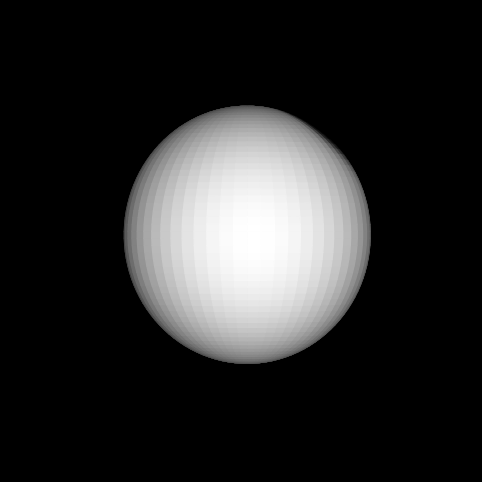

In [2]:
%matplotlib inline
#libraries
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.constants import R_sun
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from sklearn.preprocessing import normalize
import astropy.units as u
import os
from PIL import Image
import glob
import subprocess

os.makedirs("frames", exist_ok=True)#-------->creating folder to save the PNG

#functions 

# convertion function 
def convertion_radians(degree):
    return np.deg2rad(degree)

#function to calculate angular velocity    
def spot_theta(rotation_period, spot_colatitude, relative_shear):
    """
    Parameters:
    - rotation_period: rotation period of the sta
    - initial_latitude: latitud of spot(radians)
    - relative_shear: parameter between pole and equator
    Returns:
    - angular velocity.
    """
    latitude = np.pi / 2 - spot_colatitude #------->the spehre latitude is from 0  to 2pi, so in equator the colatitude will be pi?2
    angular_vel_equa= 2*np.pi*u.rad/rotation_period
    angular_velocity = angular_vel_equa*(1-relative_shear*np.sin(latitude)**2)
    return angular_velocity  

  
def flux_plot(flux):
    ''' Function take a list normalizing the flux, converting the list in a csv file and rename the columns
    and return a plot    
    '''
    flux_norm = normalize([flux], norm="max")[0]
    df = pd.DataFrame(flux_norm)
    df.to_csv("lc_high.csv")
    lc = pd.read_csv("lc_high.csv")
    lc = lc.rename(columns={'Unnamed: 0': 'Days', '0': 'flux_normalized'})#-----> change the name of the columns
    lc.to_csv('lc_high_name.csv')
    return lc.plot(x="Days", y="flux_normalized", alpha=0.5)#----->simple plot of lc


# limb darkening function 
def limbdarkening(u):
    '''calculate a limb darkening lineal and put it to the spehre'''
    return (1 - u * (1 - mu))

#limb darkening quadratic     
def quadratic(u):
    """
    Calculates the intensity of a given cell in the stellar surface using a
    quadratic limb-darkening law.
  """

    return (1 - u * (1 - mu) - u * (1 - mu) ** 2)

#limb darkening logarithmic
def logarithmic(u):
    """
    Calculates the intensity of a given cell in the stellar surface using a
    logarithmic limb-darkening law.
    """
    
    return (1 - u * (1 - mu) - u * mu * np.log(mu) ** 2)




#function that create a gaussian mask to represent spots
def spot_mask(theta_mesh, spot_theta_rad,phi_mesh,spot_phi_rad,spot_radius_rad):
    '''function for creating spot mask, that could change the size and shape of the spot
    using a gaussian function
    '''
    delta_theta = np.arccos(np.cos(theta_mesh - spot_theta_rad.value))
    delta_phi = np.abs(phi_mesh - spot_phi_rad)
    distance_squared = delta_theta**2 + delta_phi**2
    sigma_squared = (spot_radius_rad / 2)**2
    return np.exp(-distance_squared**2 / (2* sigma_squared))

def spot_mask_binary(theta_mesh, spot_theta_rad, phi_mesh, spot_phi_rad, spot_radius_rad):
    """Máscara binaria: 1 dentro del radio de la mancha, 0 fuera"""
    delta_theta = np.arccos(np.cos(theta_mesh - spot_theta_rad.value))
    delta_phi = np.abs(phi_mesh - spot_phi_rad)
    distance_squared = delta_theta**2 + delta_phi**2
    return np.where(distance_squared <= spot_radius_rad**2, 1, 0)


##function that creates spots

def add_spots(latitude_deg, longitude_deg, radii_deg):

    colatitude_rad = np.deg2rad(90 - latitude_deg)
    longitude_rad = np.deg2rad(longitude_deg)
    radii_rad = np.deg2rad(radii_deg)
    ang_vel = spot_theta(rotation_period, colatitude_rad, 0.2)  

    spots.append({'theta': longitude_rad * u.rad,'phi': colatitude_rad,'radius': radii_rad,'angular_velocity': ang_vel})



### function to create gif
def gif(input_pattern="frames/frame_%03d.png",output_gif="output.gif",palette="palette.png",framerate=17):
    """
    Creating GIF with ffmpeg.
    
    Parameters:
        input_pattern (str): Input pattern of the numbered images (e.g. 'frames/frame_%03d.png')
     output_gif (str): Name of the output GIF file
     palette (str): Name of the temporary palette file
     framerate (int): Frames per second of the GIF
    """
    # color palette
    palette_cmd = ["ffmpeg","-y","-i", input_pattern,"-vf", "palettegen",palette]

    # gif creation
    gif_cmd = ["ffmpeg","-y","-framerate", str(framerate),"-i", input_pattern,"-i", palette,"-lavfi", "paletteuse",output_gif]

    try:
        print("generating color palette")
        subprocess.run(palette_cmd, check=True)

        print("creating gif")
        subprocess.run(gif_cmd, check=True)

        print(f" GIF done: {output_gif}")
    except subprocess.CalledProcessError as e:
        print("something wrong:", e)

def flux_plot():
    '''
    Function take a list normalizing the flux, converting the list in a csv file and rename the columns
    and return a plot 

    '''
    frame_files = sorted(glob.glob("frames/frame_*.png"))
    fluxes = []

    for filename in frame_files:
        img = Image.open(filename).convert('L')  # Grayscale
        img_array = np.array(img, dtype=np.float64)
        flux_total = np.sum(img_array)
        fluxes.append(flux_total)

    # Normalized fluxes
    flux_norm = normalize([fluxes], norm="max")[0]
    df = pd.DataFrame(flux_norm)

    # Creating columns
    df.index.name = 'Frame'
    df.reset_index(inplace=True)
    #changing frames for days
    df['Days'] = df['Frame'] *(cadence_time.to(u.day)).value
    df = df.rename(columns={0: 'flux_normalized'})
    df = df[['Days', 'flux_normalized']]  

    # saving csv
    df.to_csv("starspot.csv", index=False)

    # Graficar
    ax = df.plot(x="Days", y="flux_normalized", alpha=0.5, linestyle='--', color ="blue")
    ax.set_xlabel("Time [days]")
    ax.set_ylabel("Normalized Flux")
    ax.set_title("Lightcurve from PNG frames")
    plt.tight_layout()
    plt.show()

#animation Function

def animate(i, gray_texture, mu,theta_mesh, phi_mesh,
            x, y, z, ax_sphere, elev, azim, total_frames):#ax_curve, line_curve, fluxes, total_frames):
    """ Function where is created the motion and call functions"""
    ax_sphere.clear()
    ax_sphere.set_axis_off()
    ax_sphere.view_init(elev=elev, azim=azim)
    texture = np.copy(gray_texture)

    for spot in spots:
        theta_mov = spot['theta'] + spot['angular_velocity'] * i * cadence_time.to(u.day)
        mask = spot_mask(theta_mesh, theta_mov, phi_mesh, spot['phi'], spot['radius'])
        texture *= (1 -  mask)  # Add texture to spot

    # Plot surface
    surf = ax_sphere.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.gray(texture), shade=False)
    print(f"Procesando frame {i+1}/{total_frames}, motion {theta_mov:.2f}",  end='\r')  # -------> to see the process
    
    # Png saves
    filename = f"frames/frame_{i:03d}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0)
    return[surf]

if __name__ == '__main__':
    
    # Stellar parameters 
    r = 1* u.R_sun
    res = 60#--->resolution
    constant = 0.8  # limb darkening coefficient
    rotation_period = 1* u.day #--->rotation period of the star
    
    # Point of view of the sphere
    elev = 0
    azim = 0
    
     #list of spots
    spots = []
    
    #adding spots
    #add_spots(30, 45, 10)
    #add_spots(-20, 90, 15)
    #add_spots(0, 180, 10)

    
    #parameters of how many days periods
    observing_baseline_days = 5* u.day#----> Observation time
    cadence_time = 30 * u.minute#----> Cadence
    
    # frames
    total_frames = (observing_baseline_days / cadence_time).decompose().value
    total_frames = int(total_frames) 
    
    #Parameter of differential rotation
    relative_shear_coeff = 0.2
    
    #creating angles
    theta = np.linspace(0, 2*np.pi, res)
    phi = np.linspace(0, np.pi, res)
    
    #meshgrid for creation of the sphere surface
    theta_mesh, phi_mesh = np.meshgrid(theta, phi)
    
    x = r * np.sin(phi_mesh) * np.cos(theta_mesh)
    y = r * np.sin(phi_mesh) * np.sin(theta_mesh)
    z = r * np.cos(phi_mesh)
    
    # gray texture 
    gray_texture = np.ones((res, res))  # intensity white==1
    
    #convertion paraneters
    elev_rad = convertion_radians(elev)
    azim_rad = convertion_radians(azim)
    
    v_x = np.cos(elev_rad) * np.cos(azim_rad)
    v_y = np.cos(elev_rad) * np.sin(azim_rad)
    v_z = np.sin(elev_rad)
    
    # Limb darkening
    mu = (x * v_x + y * v_y + z * v_z) / r
    mu = np.clip(mu, 0, 1)
    
    lineal_darkening = limbdarkening(constant)
    gray_texture *= lineal_darkening
      
    # Figure
    plt.style.use('dark_background')# -----> dark background
    fig = plt.figure(figsize=(12, 6))
    ax_sphere = fig.add_subplot(projection='3d') 

    ax_sphere.set_box_aspect((0.98, 1, 0.95))#-------> symtries of the sun 
 
    ax_sphere.set_axis_off()
    
    
#  Grid search parameters
    latitudes = np.arange(-60, 61, 20)
    longitudes = np.arange(0, 361, 60)
    radios = np.arange(5, 16, 5)  # en grados

    simulacion_id = 0  # identification of simulation

    for lat in latitudes:
        for lon in longitudes:
            for radius in radios:

                simulacion_id += 1
                print(f" Simulatin lat={lat}, lon={lon}, radius={radius}")

                # clean frames
                for f in glob.glob("frames/*.png"):
                    os.remove(f)

                # Reset mancha
                spots = []
                add_spots(lat, lon, radius)

                # Reset texture
                gray_texture = np.copy(gray_texture)


                for i in range(total_frames):
                    animate(i, gray_texture, mu, theta_mesh, phi_mesh, x, y, z,
                            ax_sphere, elev, azim, total_frames)

                # Name gif
                gif_name = f"gif_l{lat}_lo{lon}_r{radius}.gif"
                gif(input_pattern="frames/frame_%03d.png", output_gif=gif_name, framerate=15)

                # saving lc 
                fluxes = []
                frame_files = sorted(glob.glob("frames/frame_*.png"))
                for filename in frame_files:
                    img = Image.open(filename).convert('L')
                    img_array = np.array(img, dtype=np.float64)
                    flux_total = np.sum(img_array)
                    fluxes.append(flux_total)

                flux_norm = normalize([fluxes], norm="max")[0]
                df = pd.DataFrame(flux_norm)
                df.index.name = 'Frame'
                df.reset_index(inplace=True)
                df['Days'] = df['Frame'] * (cadence_time.to(u.day)).value
                df = df.rename(columns={0: 'flux_normalized'})
                df = df[['Days', 'flux_normalized']]
                df.to_csv(f"lightcurve_l{lat}_lo{lon}_r{radius}.csv", index=False)


  


In [1]:


# 1.read csv
lc_dummy = pd.read_csv("lc_dummy.csv")  # <- cambia el nombre si es necesario
t_dummy = lc_dummy["Days"]
flux_dummy = lc_dummy["flux_normalized"]

# sorting values
lc_dummy = lc_dummy.sort_values("Days")

# 2. looking for csv
csv_files = glob.glob("lc/lightcurve_l*_lo*_r*.csv")

# List of results
mse_results = []

# comparing lc
for file in csv_files:
    df = pd.read_csv(file)
    df = df.sort_values("Days")  # sorting value time
    t = df["Days"]
    flux = df["flux_normalized"]
    
    # interpolate
    
    
    # 4. MSE
    mse = mean_squared_error(flux_dummy, flux)
    
    # results
    mse_results.append((file, mse))

# 5. sorting
mse_results = sorted(mse_results, key=lambda x: x[1])

# Best curves
print("\nTop 5 best lc with low MSE:")
for i, (file, mse) in enumerate(mse_results[:5]):
    print(f"{i+1}. {file} -> MSE: {mse:.6f}")

# plotting
best_file = mse_results[0][0]
best_df = pd.read_csv(best_file)
flux_best = np.interp(t_dummy, best_df["Days"], best_df["flux_normalized"])

plt.figure(figsize=(10, 5))
plt.plot(t_dummy, flux_dummy, label="Dummy Curve", lw=2)
plt.plot(t_dummy, flux_best, label=f"Best Match: {best_file}", lw=2, linestyle="--")
plt.xlabel("Days")
plt.ylabel("Flux")
plt.title("Comparison of Lightcurves")
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'pd' is not defined